In [ ]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [15]:
import numpy as np
import pandas as pd
import datetime as dt
import matplotlib.pyplot as plt

## Reflect Tables into SQLALchemy ORM

In [1]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [2]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [3]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [4]:
# View all of the classes that automap found

Base.classes.keys()


['measurement', 'station']

In [5]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [6]:
# Create our session (link) from Python to the DB
session = Session(engine)

## Bonus Challenge Assignment: Temperature Analysis II

In [7]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, maximum, and average temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# For example
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


In [13]:
# Use the function `calc_temps` to calculate the tmin, tavg, and tmax 
# for a year in the data set
startdate = '2015-01-01'
enddate = '2018-01-07'
tempresult = calc_temps(startdate,enddate)[0]
tempresult

(56.0, 74.03199477636305, 87.0)

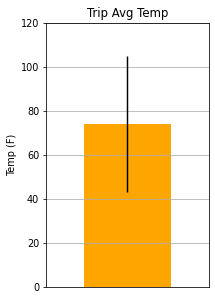

In [17]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for bar height (y value)
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)

x_pos = [0]
y_pos = [tempresult[1]]
error = [(tempresult[2] - tempresult[0])]

w = 3
h = 5
d = 70
plt.figure(figsize=(w, h), dpi=d)
plt.bar(x_pos,y_pos,color='orange', yerr=error)
plt.xlim(-0.75,0.75)
plt.title("Trip Avg Temp")
plt.ylabel("Temp (F)")
plt.ylim(0, 120)
plt.tick_params(axis='x',which='both',bottom=False,top=False,labelbottom=False)
plt.grid(which='major', axis='x', linestyle='')
plt.grid(which='major', axis='y', linestyle='-')
plt.show()

### Daily Rainfall Average

In [18]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's 
# matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation

startdate = '2015-01-01'
enddate = '2018-01-07'

sel = [Station.station,Station.name,Station.latitude,Station.longitude,Station.elevation,func.sum(Measurement.prcp)]
queryresult = session.query(*sel).\
    filter(Station.station == Measurement.station).\
    group_by(Measurement.station).\
    filter(Measurement.date >= startdate).\
    filter(Measurement.date <= enddate).\
    order_by(func.sum(Measurement.prcp).desc()).\
    all()
  
stations = pd.DataFrame(queryresult, columns=['Station','Name','Latitude','Longitude','Elevation','PrcpSum'])
stations


,Station,Name,Latitude,Longitude,Elevation,PrcpSum
0,USC00516128,"MANOA LYON ARBO 785.2, HI US",21.33310,-157.80250,152.4,397.18
1,USC00519281,"WAIHEE 837.5, HI US",21.45167,-157.84889,32.9,211.25
2,USC00513117,"KANEOHE 838.1, HI US",21.42340,-157.80150,14.6,140.26
3,USC00519523,"WAIMANALO EXPERIMENTAL FARM, HI US",21.33556,-157.71139,19.5,115.02
4,USC00514830,"KUALOA RANCH HEADQUARTERS 886.9, HI US",21.52130,-157.83740,7.0,90.64
5,USC00519397,"WAIKIKI 717.2, HI US",21.27160,-157.81680,3.0,45.17
6,USC00517948,"PEARL CITY, HI US",21.39340,-157.97510,11.9,9.98
7,USC00511918,"HONOLULU OBSERVATORY 702.2, HI US",21.31520,-157.99920,0.9,6.09
8,USC00518838,"UPPER WAHIAWA 874.3, HI US",21.49920,-158.01110,306.6,0.00


In [19]:
# Use this function to calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()

# For example
daily_normals("01-01")

[(62.0, 69.15384615384616, 77.0)]

In [20]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`

# Set the start and end date of the trip
start_date = '2017-08-01'
end_date = '2017-08-07'

# Use the start and end date to create a range of dates
dtobj = dt.datetime.strptime(startdate, '%Y-%m-%d')
enddtobj = dt.datetime.strptime(enddate, '%Y-%m-%d')

# Strip off the year and save a list of strings in the format %m-%d
tripdates = []
normals =[]
while (dtobj <= enddtobj):
    tripdates.append(dt.datetime.strftime(dtobj,'%Y-%m-%d'))
    datestr = dt.datetime.strftime(dtobj,'%m-%d')
    normals.append(list(np.ravel(daily_normals(datestr))))
    dtobj = dtobj + dt.timedelta(days = 1)

# Use the `daily_normals` function to calculate the normals for each date string 
# and append the results to a list called `normals`.
normals

[[62.0, 69.15384615384616, 77.0],
 [60.0, 69.39622641509433, 77.0],
 [62.0, 68.9090909090909, 77.0],
 [58.0, 70.0, 76.0],
 [56.0, 67.96428571428571, 76.0],
 [61.0, 68.96491228070175, 76.0],
 [57.0, 68.54385964912281, 76.0],
 [57.0, 67.16071428571429, 75.0],
 [58.0, 67.9298245614035, 78.0],
 [62.0, 69.74137931034483, 77.0],
 [57.0, 67.3103448275862, 78.0],
 [57.0, 67.4074074074074, 81.0],
 [57.0, 67.25454545454545, 77.0],
 [58.0, 69.52631578947368, 77.0],
 [56.0, 69.31372549019608, 78.0],
 [54.0, 68.62962962962963, 80.0],
 [61.0, 69.07407407407408, 76.0],
 [57.0, 68.63157894736842, 77.0],
 [60.0, 68.26315789473684, 78.0],
 [61.0, 68.86666666666666, 78.0],
 [61.0, 70.14545454545454, 76.0],
 [60.0, 69.26415094339623, 76.0],
 [57.0, 69.50909090909092, 79.0],
 [58.0, 68.76271186440678, 78.0],
 [61.0, 67.94915254237289, 75.0],
 [61.0, 70.58620689655173, 77.0],
 [59.0, 68.56896551724138, 75.0],
 [62.0, 69.03703703703704, 77.0],
 [64.0, 69.14, 76.0],
 [60.0, 67.12962962962963, 77.0],
 [60.0, 6

In [21]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index
df = pd.DataFrame(normals, columns=['tmin','tavg','tmax'])
df['Date'] = tripdates
df = df.set_index("Date")
df

,tmin,tavg,tmax
Date,,,
2015-01-01,62.0,69.153846,77.0
2015-01-02,60.0,69.396226,77.0
2015-01-03,62.0,68.909091,77.0
2015-01-04,58.0,70.000000,76.0
2015-01-05,56.0,67.964286,76.0
...,...,...,...
2018-01-03,62.0,68.909091,77.0
2018-01-04,58.0,70.000000,76.0
2018-01-05,56.0,67.964286,76.0


(array([-200.,    0.,  200.,  400.,  600.,  800., 1000., 1200.]),
 [Text(-200.0, 0, '2017-06-22'),
  Text(0.0, 0, '2015-01-01'),
  Text(200.0, 0, '2015-07-20'),
  Text(400.0, 0, '2016-02-05'),
  Text(600.0, 0, '2016-08-23'),
  Text(800.0, 0, '2017-03-11'),
  Text(1000.0, 0, '2017-09-27'),
  Text(1200.0, 0, '')])

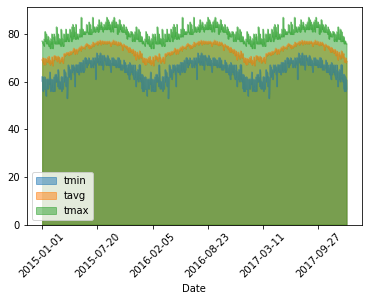

In [23]:
# Plot the daily normals as an area plot with `stacked=False`
df.plot.area(stacked=False)
plt.xticks(rotation=45)

## Close Session

In [24]:
# Close Session
session.close()